# Modeling and Simulation in Python

Chapter 6: Analysis

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


We'll start with the same code we saw last time: the magic command that tells Jupyter where to put the figures, and the import statement that gets the function defined in the `modsim` module.

In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt

# To switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

In [2]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= np.sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

In [3]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

sir = make_system(beta, gamma)

In [4]:
def update1(system, state):
    """Update the SIR model.
    
    system: System object
    state: StateVector (s, i, r)
    
    returns: StateVector (sir)
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

In [5]:
def run_model(system, update_func):
    df = DataFrame(columns=['S', 'I', 'R'])
    df.loc[0] = system.init
    
    for i in range(system.t0, system.t_end):
        df.loc[i+1] = update_func(system, df.loc[i])
    
    system.results = df

In [6]:
def plot_results(S, I, R):
    plot(S, '--', color='blue', label='Susceptible')
    plot(I, '-', color='red', label='Infected')
    plot(R, ':', color='green', label='Resistant')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

In [7]:
sir = make_system(beta, gamma)
run_model(sir, update1)
sir.results.head()

,S,I,R
0,0.988889,0.011111,0.000000
1,0.985226,0.011996,0.002778
2,0.981287,0.012936,0.005777
3,0.977055,0.013934,0.009011
4,0.972517,0.014988,0.012494


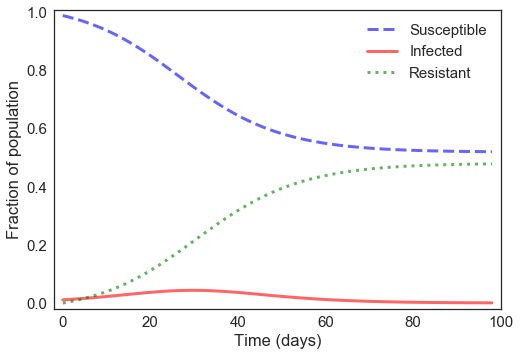

In [8]:
df = sir.results
plot_results(df.S, df.I, df.R)

In [9]:
def calc_total_infected(system):
    df = system.results
    return df.S[system.t0] - df.S[system.t_end]

In [10]:
sir.beta = 0.333
sir.gamma = 0.25
run_model(sir, update1)
print(sir.beta, sir.gamma, calc_total_infected(sir))

0.333 0.25 0.467162931836


### Sweeping beta

In [11]:
beta_array = linspace(0.1, 0.9, 11)
gamma = 0.25

In [12]:
for beta in beta_array:
    sir = make_system(beta, gamma)
    run_model(sir, update1)
    print(sir.beta, calc_total_infected(sir))

0.1 0.00723090166498
0.18 0.0262722567457
0.26 0.160575485321
0.34 0.490862856866
0.42 0.689867847411
0.5 0.804506112463
0.58 0.873610307851
0.66 0.916554007142
0.74 0.943729262152
0.82 0.961060480958
0.9 0.972099315633


In [14]:
def sweep_beta(beta_array, gamma):
    sweep = Sweep()
    for beta in beta_array:
        system = make_system(beta, gamma)
        run_model(system, update1)
        sweep[system.beta] = calc_total_infected(system)
    return sweep

In [15]:
infected_sweep = sweep_beta(beta_array, gamma)

Saving figure to file chap06-fig01.pdf


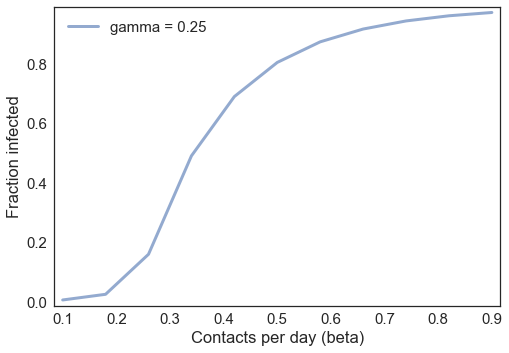

In [16]:
label = 'gamma = ' + str(gamma)
plot(infected_sweep, label=label)
decorate(xlabel='Contacts per day (beta)',
         ylabel='Fraction infected')

savefig('chap06-fig01.pdf')

### Sweeping gamma

In [17]:
beta_array = linspace(0.1, 0.9, 11)
beta_array

array([ 0.1 ,  0.18,  0.26,  0.34,  0.42,  0.5 ,  0.58,  0.66,  0.74,
        0.82,  0.9 ])

In [18]:
gamma_array = linspace(0.1, 0.7, 4)
gamma_array

array([ 0.1,  0.3,  0.5,  0.7])

Saving figure to file chap06-fig02.pdf


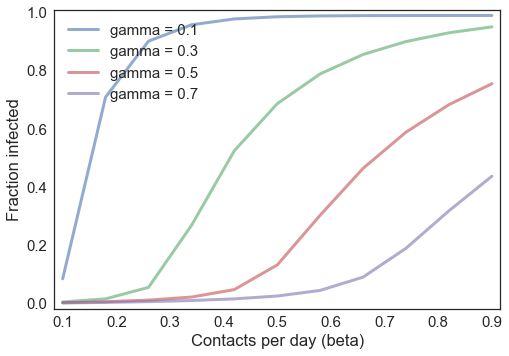

In [19]:
for gamma in gamma_array:
    infected_sweep = sweep_beta(beta_array, gamma)
    label = 'gamma = ' + str(gamma)
    plot(infected_sweep, label=label)
    
decorate(xlabel='Contacts per day (beta)',
         ylabel='Fraction infected',
         loc='upper left')

savefig('chap06-fig02.pdf')

In [20]:
def sweep_parameters(beta_array, gamma_array):
    df = DataFrame(columns=gamma_array)
    for gamma in gamma_array:
        df[gamma] = sweep_beta(beta_array, gamma)
    return df

In [21]:
sweep_df = sweep_parameters(beta_array, gamma_array)
sweep_df.head()

,0.1,0.3,0.5,0.7
0.10,0.084693,0.005444,0.002736,0.001827
0.18,0.708623,0.015914,0.006118,0.003783
0.26,0.900780,0.055380,0.011639,0.006427
0.34,0.956888,0.267864,0.022115,0.010191
0.42,0.977045,0.524563,0.047816,0.015946


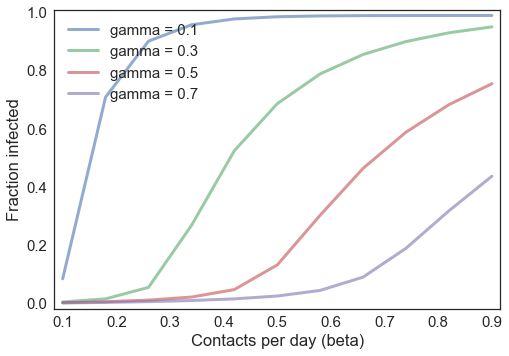

In [22]:
for gamma in gamma_array:
    label = 'gamma = ' + str(gamma)
    plot(sweep_df[gamma], label=label)
    
decorate(xlabel='Contacts per day (beta)',
         ylabel='Fraction infected',
         loc='upper left')

### Contact number

In [23]:
sweep_df.shape

(11, 4)

In [24]:
for gamma in sweep_df.columns:
    sweep = sweep_df[gamma]
    for beta in sweep.index:
        frac_infected = sweep[beta]
        print(beta, gamma, frac_infected)

0.1 0.1 0.0846929424381
0.18 0.1 0.70862278537
0.26 0.1 0.900780251778
0.34 0.1 0.956887899544
0.42 0.1 0.977045257074
0.5 0.1 0.984595862826
0.58 0.1 0.987400345318
0.66 0.1 0.988404249064
0.74 0.1 0.988743421406
0.82 0.1 0.988849515052
0.9 0.1 0.988879570517
0.1 0.3 0.00544355912239
0.18 0.3 0.0159140691448
0.26 0.3 0.0553797621068
0.34 0.3 0.267864167733
0.42 0.3 0.524562935844
0.5 0.3 0.686050483916
0.58 0.3 0.788378556339
0.66 0.3 0.85506574641
0.74 0.3 0.89947913569
0.82 0.3 0.929469302619
0.9 0.3 0.949853310327
0.1 0.5 0.00273576554115
0.18 0.5 0.00611834135832
0.26 0.5 0.0116394693217
0.34 0.5 0.0221147665242
0.42 0.5 0.0478162266689
0.5 0.5 0.132438038458
0.58 0.5 0.303264192648
0.66 0.5 0.464110227319
0.74 0.5 0.588476972528
0.82 0.5 0.682749610978
0.9 0.5 0.754595298329
0.1 0.7 0.001826769347
0.18 0.7 0.00378256160842
0.26 0.7 0.00642667221076
0.34 0.7 0.0101905519335
0.42 0.7 0.0159458265615
0.5 0.7 0.0257079250464
0.58 0.7 0.0450077531168
0.66 0.7 0.0906940688294
0.74 0.7 

In [25]:
def plot_sweep_df(df):
    for gamma in df.columns:
        sweep = df[gamma]
        for beta in sweep.index:
            frac_infected = sweep[beta]
            plot(beta / gamma, frac_infected, 'ro')

Saving figure to file chap06-fig03.pdf


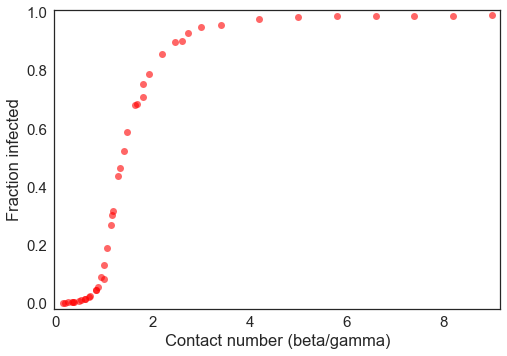

In [26]:
plot_sweep_df(sweep_df)

decorate(xlabel='Contact number (beta/gamma)',
         ylabel='Fraction infected',
         legend=False)

savefig('chap06-fig03.pdf')

**Exercise:** It turns out that the ratio `beta/gamma`, called the "contact number" is sufficient to predict the total number of infections; we don't have to know `beta` and `gamma` separately.  We can see that in the previous plot: when we plot the fraction infected versus the contact number, the results fall close to a curve.

But if we didn't know about the contact number, we might have explored other possibilities, like the difference between `beta` and `gamma`, rather than their ratio.

Write a version of `plot_sweep_df`, called `plot_sweep_df_difference`, that plots the fraction infected versus the difference `beta-gamma`.

What do the results look like, and what does that imply? 

In [27]:
# Solution

def plot_sweep_df_difference(df):
    for gamma in df.columns:
        sweep = df[gamma]
        for beta in sweep.index:
            frac_infected = sweep[beta]
            plot(beta - gamma, frac_infected, 'ro')

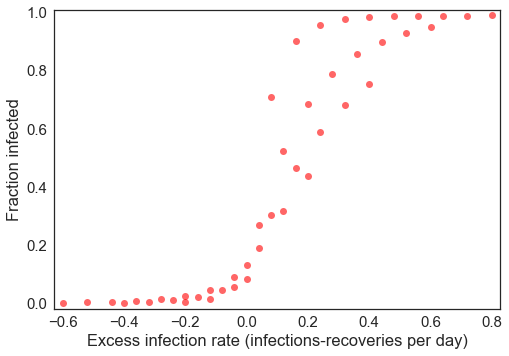

In [28]:
# Solution

plot_sweep_df_difference(sweep_df)

decorate(xlabel='Excess infection rate (infections-recoveries per day)',
         ylabel='Fraction infected',
         legend=False)

### Analysis

In [32]:
s_inf_array = linspace(0.001, 0.999, 31)
s_inf_array

array([ 0.001     ,  0.03426667,  0.06753333,  0.1008    ,  0.13406667,
        0.16733333,  0.2006    ,  0.23386667,  0.26713333,  0.3004    ,
        0.33366667,  0.36693333,  0.4002    ,  0.43346667,  0.46673333,
        0.5       ,  0.53326667,  0.56653333,  0.5998    ,  0.63306667,
        0.66633333,  0.6996    ,  0.73286667,  0.76613333,  0.7994    ,
        0.83266667,  0.86593333,  0.8992    ,  0.93246667,  0.96573333,
        0.999     ])

In [33]:
c_array = np.log(s_inf_array) / (s_inf_array - 1)
c_array

array([ 6.91466995,  3.49328546,  2.89032742,  2.55184266,  2.32052285,
        2.14703857,  2.00956017,  1.89654211,  1.80115624,  1.71903996,
        1.6472428 ,  1.58368013,  1.52682704,  1.47553609,  1.42892337,
        1.38629436,  1.34709399,  1.3108721 ,  1.2772589 ,  1.24594716,
        1.21667902,  1.18923614,  1.1634321 ,  1.13910658,  1.1161208 ,
        1.09435385,  1.07369982,  1.05406547,  1.03536833,  1.01753508,
        1.00050033])

In [34]:
frac_infected_analysis = Series(1 - s_inf_array, index=c_array)

Saving figure to file chap06-fig04.pdf


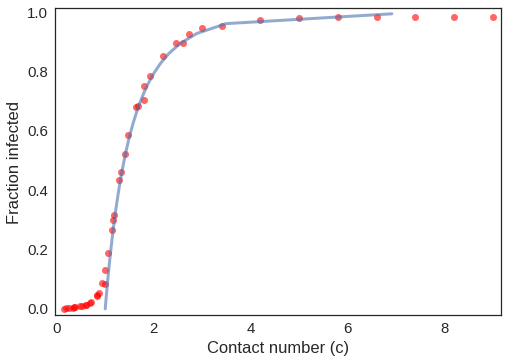

In [35]:
plot_sweep_df(sweep_df)
plot(frac_infected_analysis)

decorate(xlabel='Contact number (c)',
         ylabel='Fraction infected',
         legend=False)

savefig('chap06-fig04.pdf')